# BGP Anomaly Detection using SVM

This notebook explores how to use Support Vector Machines (SVM) for detecting BGP routing anomalies using the feature-rich datasets extracted by the BGP Feature Extractor tool.

## What is BGP?

Border Gateway Protocol (BGP) is the routing protocol that enables the global internet to function by allowing autonomous systems (ASes) to exchange network reachability information. BGP anomalies can include route hijacks, leaks, configuration errors, or infrastructure failures that disrupt normal internet routing.

## What are we doing in this notebook?

1. Load and explore labeled BGP features from a dataset
2. Preprocess the data for machine learning
3. Train an SVM model to detect anomalies
4. Evaluate the model's performance using ROC curves, precision-recall curves, etc.
5. Explain model predictions using SHAP and LIME
6. Visualize the results

In [1]:
!pip install shap
!pip install lime

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_recall_fscore_support, roc_curve, auc, 
    precision_recall_curve, average_precision_score
)
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import joblib
import warnings

# Import explainability libraries if installed
try:
    import shap
    import lime
    import lime.lime_tabular
    EXPLAINABILITY_AVAILABLE = True
except ImportError:
    EXPLAINABILITY_AVAILABLE = False
    print("Warning: SHAP and/or LIME libraries not installed. Explainability sections will be skipped.")
    print("Run 'pip install shap lime' to install them.")

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Loading the Dataset

We'll load a dataset that contains BGP features extracted from an anomaly event. For this example, we'll use a dataset from the Code Red worm incident, which caused significant routing disruption.

In [3]:
# Load the dataset - update the path to the dataset file you want to use
dataset_path = "datasets/ratios/dataset_slammer_559_1_rrc04.csv"
df = pd.read_csv(dataset_path)

# Check the first few rows
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (7200, 31)


,Unnamed: 0,announcements,as_path_max,class,nlri_ann,number_rare_ases,origin_changes,rare_ases_avg,rare_ases_max,ratio_ann,...,ratio_origin0,ratio_origin1,ratio_origin2,ratio_shorter,ratio_shorter2,ratio_wd,timestamp,timestamp2,unique_as_path_avg,withdrawals
0,0,3,6,0,3,0,0,0.0,0,1.000000,...,1.0,0.0,0.0,0.000000,0.0,0.000000,2003-01-23 00:00:08,1043280008,7,0
1,1,3,6,0,3,0,0,0.0,0,0.103448,...,1.0,0.0,0.0,0.000000,0.0,0.896552,2003-01-23 00:01:08,1043280068,5,26
2,2,7,4,0,7,0,0,0.0,0,0.583333,...,1.0,0.0,0.0,0.000000,0.0,0.416667,2003-01-23 00:02:08,1043280128,4,5
3,3,21,6,0,21,0,0,0.0,0,0.840000,...,1.0,0.0,0.0,0.000000,0.0,0.160000,2003-01-23 00:03:08,1043280188,4,4
4,4,12,9,0,8,0,0,0.0,0,0.324324,...,1.0,0.0,0.0,0.333333,1.0,0.675676,2003-01-23 00:04:08,1043280248,7,25


## 2. Data Exploration and Preprocessing

In [4]:
# Check basic statistics
df.describe()

,Unnamed: 0,announcements,as_path_max,class,nlri_ann,number_rare_ases,origin_changes,rare_ases_avg,rare_ases_max,ratio_ann,...,ratio_news,ratio_origin0,ratio_origin1,ratio_origin2,ratio_shorter,ratio_shorter2,ratio_wd,timestamp2,unique_as_path_avg,withdrawals
count,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,...,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7.200000e+03,7200.000000,7200.000000
mean,3599.500000,20.543889,7.964722,0.156944,19.075000,0.473889,0.194306,0.043172,0.271806,0.609943,...,0.035449,0.873223,0.002760,0.083878,0.144880,0.347018,0.381029,1.043496e+09,5.534861,12.854306
std,2078.605302,47.234158,3.452313,0.363774,43.692633,1.866539,0.930952,0.162425,0.595519,0.268264,...,0.127148,0.242026,0.029733,0.162169,0.219554,0.399339,0.264384,1.247163e+05,2.337101,30.685315
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.043280e+09,0.000000,0.000000
25%,1799.750000,3.000000,6.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.444444,...,0.000000,0.833333,0.000000,0.000000,0.000000,0.000000,0.176471,1.043388e+09,4.000000,1.000000
50%,3599.500000,7.000000,8.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.627501,...,0.000000,1.000000,0.000000,0.000000,0.024100,0.111111,0.363636,1.043496e+09,5.000000,4.000000
75%,5399.250000,17.000000,11.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.812500,...,0.000000,1.000000,0.000000,0.120303,0.218296,0.666667,0.545455,1.043604e+09,7.000000,11.000000
max,7199.000000,681.000000,23.000000,1.000000,584.000000,50.000000,20.000000,3.000000,5.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.043712e+09,22.000000,454.000000


In [5]:
# Check for missing values
print("Missing values in each column:")
df.isnull().sum()

Missing values in each column:


Unnamed: 0            0
announcements         0
as_path_max           0
class                 0
nlri_ann              0
number_rare_ases      0
origin_changes        0
rare_ases_avg         0
rare_ases_max         0
ratio_ann             0
ratio_dups            0
ratio_exp_wd          0
ratio_flaps           0
ratio_imp_wd          0
ratio_imp_wd2         0
ratio_imp_wd_dpath    0
ratio_imp_wd_spath    0
ratio_longer          0
ratio_longer2         0
ratio_nadas           0
ratio_news            0
ratio_origin0         0
ratio_origin1         0
ratio_origin2         0
ratio_shorter         0
ratio_shorter2        0
ratio_wd              0
timestamp             0
timestamp2            0
unique_as_path_avg    0
withdrawals           0
dtype: int64

In [6]:
# Fill missing values with 0 (if any)
df = df.fillna(0)

Class distribution:
class
0    6070
1    1130
Name: count, dtype: int64


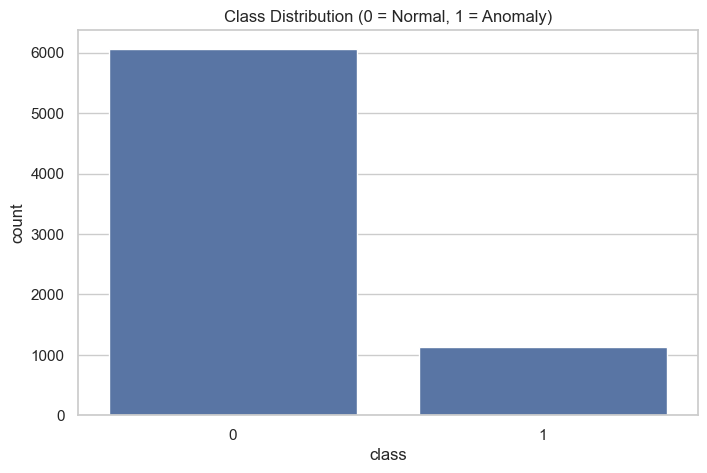

In [7]:
# Check class distribution
print("Class distribution:")
print(df['class'].value_counts())

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=df)
plt.title('Class Distribution (0 = Normal, 1 = Anomaly)')
plt.show()

In [8]:
# Drop non-feature columns
columns_to_drop = ['timestamp', 'timestamp2', 'Unnamed: 0']
for col in columns_to_drop:
    if col in df.columns:
        df = df.drop(col, axis=1)

# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

# Display feature names
print(f"Number of features: {X.shape[1]}")
print("Feature names:")
X.columns.tolist()

Number of features: 27
Feature names:


['announcements',
 'as_path_max',
 'nlri_ann',
 'number_rare_ases',
 'origin_changes',
 'rare_ases_avg',
 'rare_ases_max',
 'ratio_ann',
 'ratio_dups',
 'ratio_exp_wd',
 'ratio_flaps',
 'ratio_imp_wd',
 'ratio_imp_wd2',
 'ratio_imp_wd_dpath',
 'ratio_imp_wd_spath',
 'ratio_longer',
 'ratio_longer2',
 'ratio_nadas',
 'ratio_news',
 'ratio_origin0',
 'ratio_origin1',
 'ratio_origin2',
 'ratio_shorter',
 'ratio_shorter2',
 'ratio_wd',
 'unique_as_path_avg',
 'withdrawals']

## 3. Feature Analysis and Selection

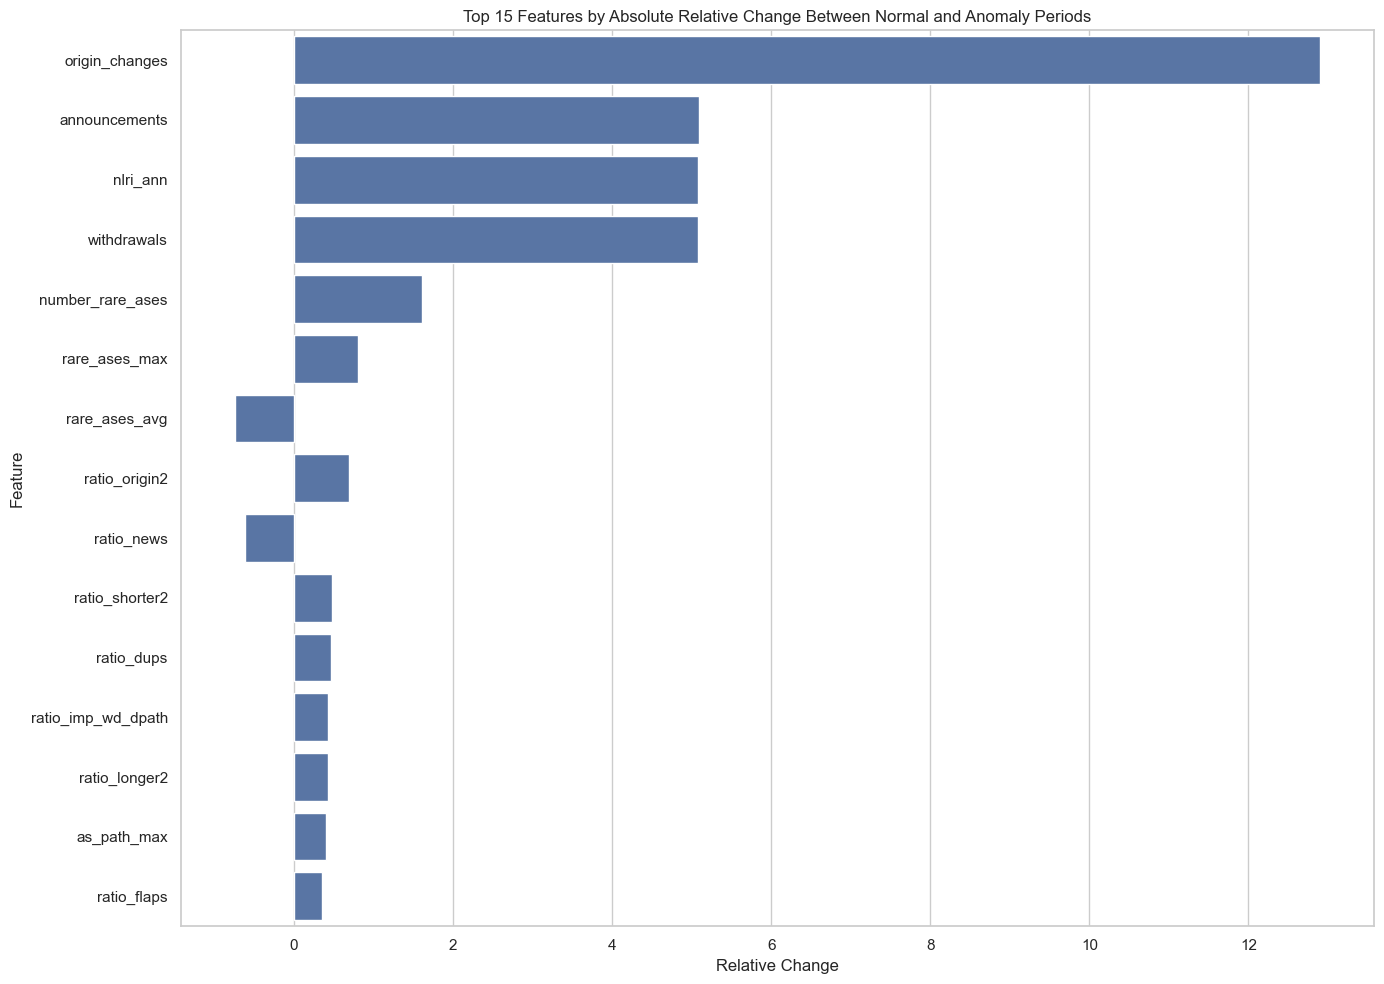

In [9]:
# Analyze feature importance for anomaly detection
# For each feature, calculate the mean difference between normal and anomaly periods
anomaly = df[df['class'] == 1]
normal = df[df['class'] == 0]

# Calculate mean differences
feature_diffs = {}
for col in X.columns:
    if col != 'class':
        normal_mean = normal[col].mean()
        anomaly_mean = anomaly[col].mean() if not anomaly.empty else 0
        
        # Prevent division by zero
        if normal_mean == 0:
            if anomaly_mean == 0:
                diff = 0
            else:
                diff = float('inf')
        else:
            diff = (anomaly_mean - normal_mean) / normal_mean
        
        feature_diffs[col] = diff

# Convert to DataFrame for better visualization
feature_diff_df = pd.DataFrame(list(feature_diffs.items()), columns=['Feature', 'Relative Change'])
feature_diff_df = feature_diff_df.sort_values('Relative Change', key=abs, ascending=False)

# Plot top features by absolute difference
plt.figure(figsize=(14, 10))
sns.barplot(x='Relative Change', y='Feature', data=feature_diff_df.head(15))
plt.title('Top 15 Features by Absolute Relative Change Between Normal and Anomaly Periods')
plt.tight_layout()
plt.show()

In [10]:
# Select top features based on difference analysis
top_features = feature_diff_df.head(15)['Feature'].tolist()
print("Selected top features:")
print(top_features)

# Extract selected features from dataset
X_selected = X[top_features]

Selected top features:
['origin_changes', 'announcements', 'nlri_ann', 'withdrawals', 'number_rare_ases', 'rare_ases_max', 'rare_ases_avg', 'ratio_origin2', 'ratio_news', 'ratio_shorter2', 'ratio_dups', 'ratio_imp_wd_dpath', 'ratio_longer2', 'as_path_max', 'ratio_flaps']


## 4. Train-Test Split

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (5040, 15)
Testing set size: (2160, 15)


In [12]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

## 5. SVM Model Training and Hyperparameter Tuning

In [13]:
# Create a pipeline with preprocessing and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

# Define the hyperparameter search space
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto', 0.1, 0.01],
    'svm__kernel': ['rbf', 'linear', 'poly']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best CV score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found:
{'svm__C': 100, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Best CV score: 0.9319


In [14]:
# Get the best model
best_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

## 6. Model Evaluation with Advanced Metrics

In [15]:
# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8977
Precision: 0.6630
Recall: 0.7080
F1 Score: 0.6847

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1821
           1       0.66      0.71      0.68       339

    accuracy                           0.90      2160
   macro avg       0.80      0.82      0.81      2160
weighted avg       0.90      0.90      0.90      2160



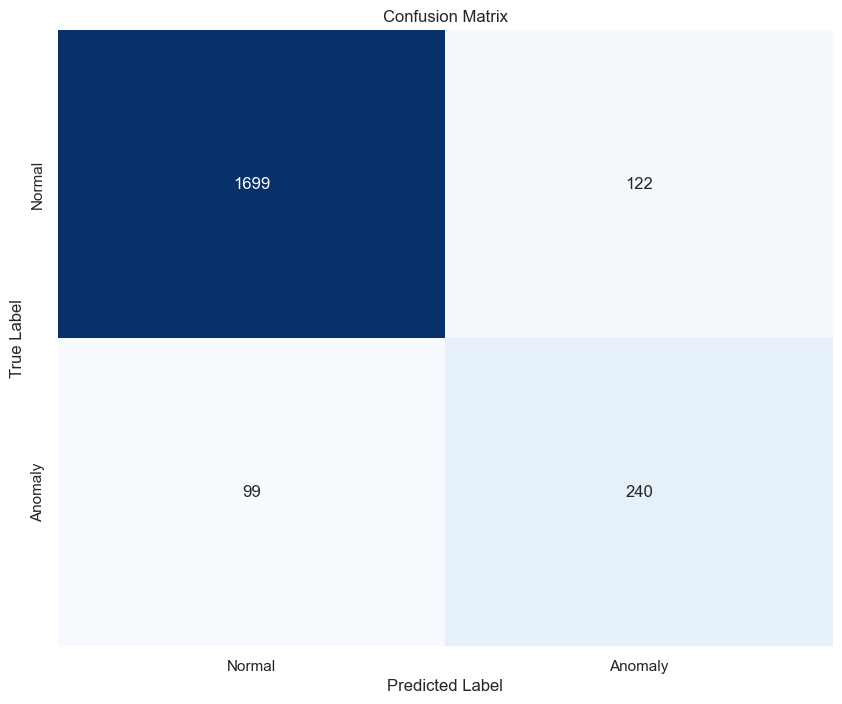

In [16]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

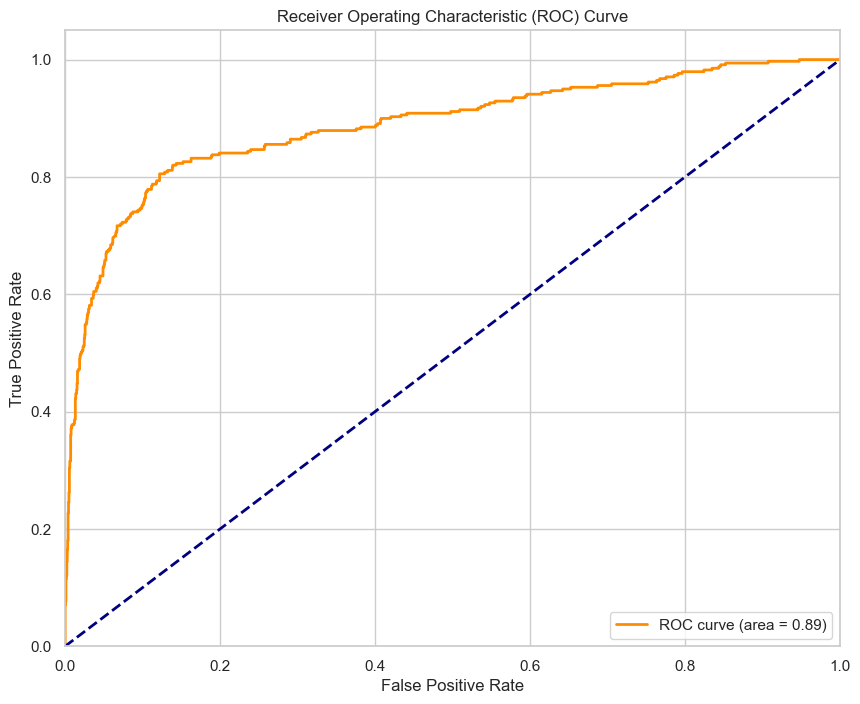

In [17]:
# Calculate and plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

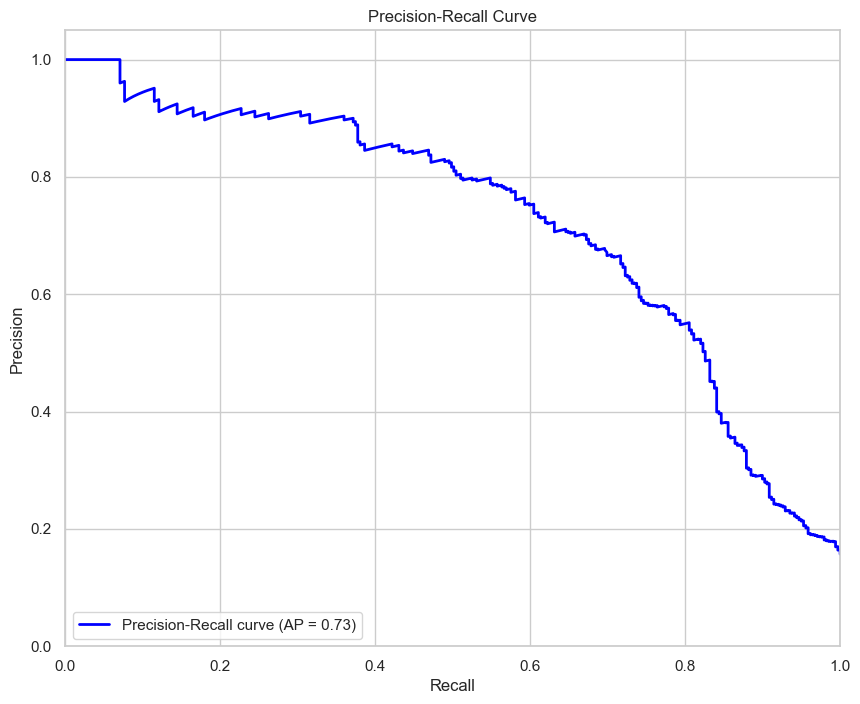

In [18]:
# Calculate and plot Precision-Recall curve
precision_values, recall_values, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(10, 8))
plt.plot(recall_values, precision_values, color='blue', lw=2, 
         label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

## 7. Visualizing Decision Boundaries

Let's use PCA to reduce our features to 2 dimensions and visualize the SVM decision boundary.

Explained variance ratio: [0.2338786  0.13476629]
Total explained variance: 0.37


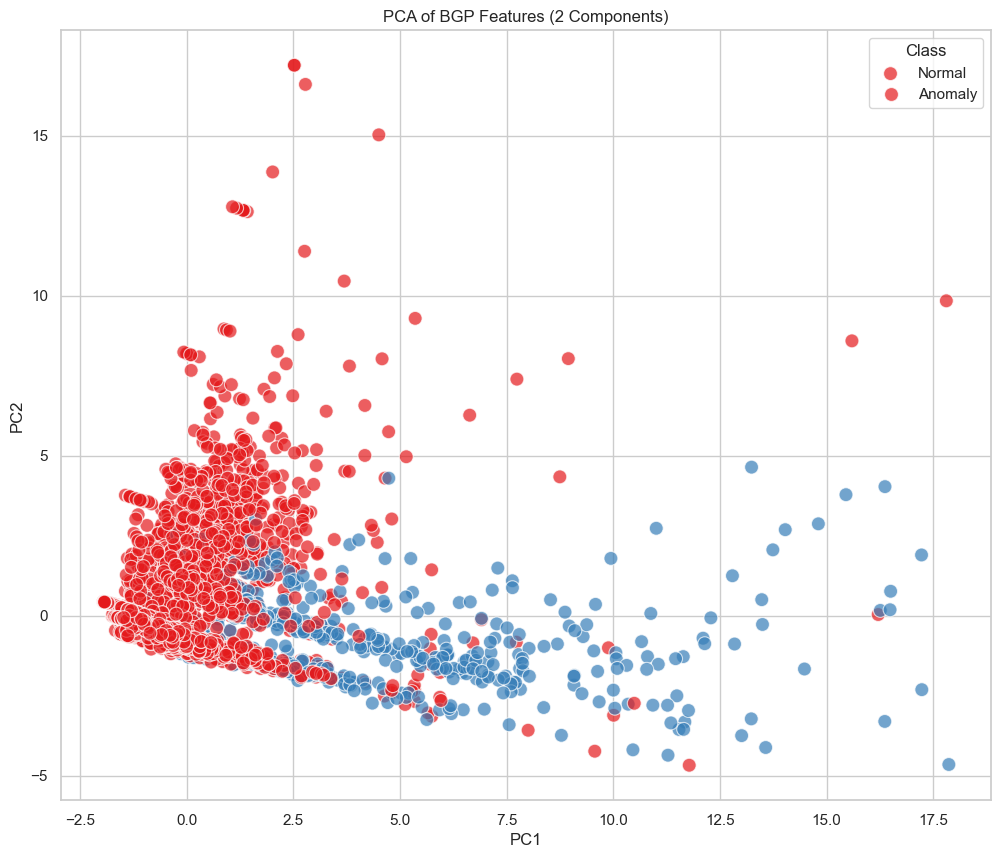

In [19]:
# Apply PCA to reduce to 2 dimensions for visualization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Explained variance
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2f}")

# Create a DataFrame for easier plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['class'] = y.values

# Plot PCA results
plt.figure(figsize=(12, 10))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df, palette='Set1', s=100, alpha=0.7)
plt.title('PCA of BGP Features (2 Components)')
plt.legend(title='Class', labels=['Normal', 'Anomaly'])
plt.show()

<Figure size 1400x1200 with 0 Axes>

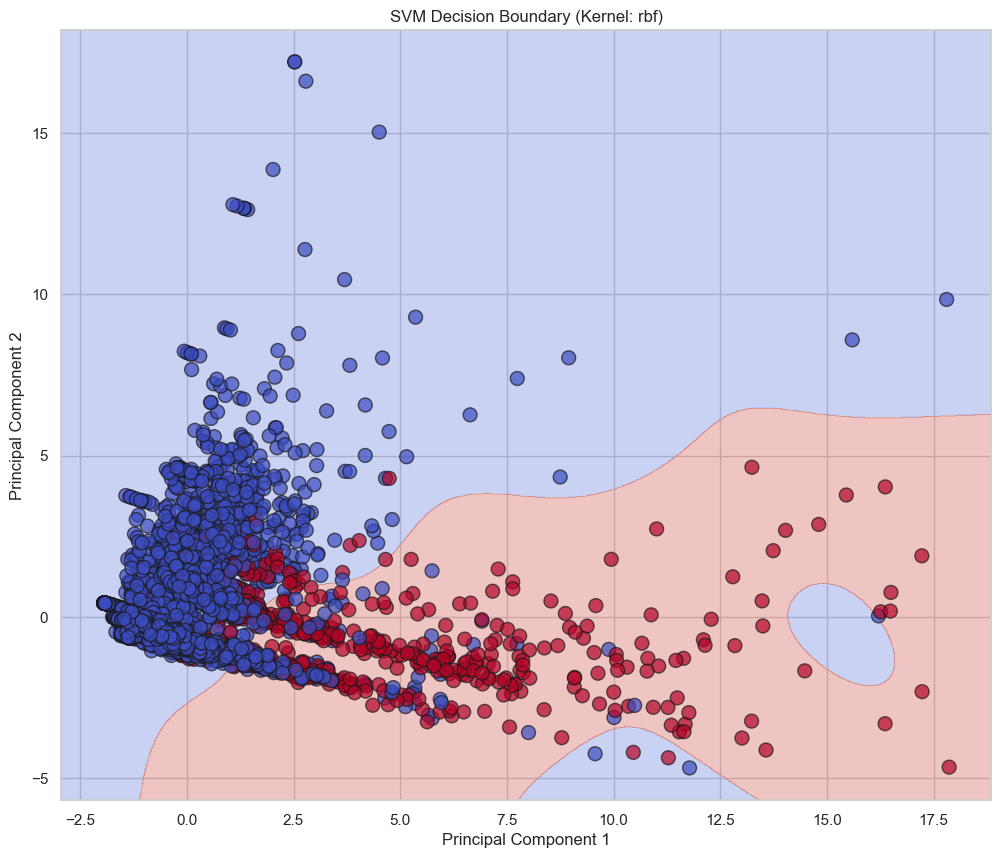

In [20]:
# Train an SVM on the PCA-transformed data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=0.3, random_state=42, stratify=y
)

# Use best parameters from grid search but adapt to the 2D case
best_params = grid_search.best_params_
svm_2d = SVC(
    C=best_params['svm__C'],
    gamma=best_params['svm__gamma'] if best_params['svm__gamma'] not in ['scale', 'auto'] else 'scale',
    kernel=best_params['svm__kernel'],
    probability=True
)
svm_2d.fit(X_train_pca, y_train_pca)

# Plot decision boundary
def plot_decision_boundary(X, y, model, ax=None):
    h = 0.02  # Step size in the mesh
    
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Get predictions for each point in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    if ax is None:
        plt.figure(figsize=(12, 10))
        ax = plt.gca()
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=100, alpha=0.7, edgecolors='k')
    return ax

plt.figure(figsize=(14, 12))
ax = plot_decision_boundary(X_pca, y.values, svm_2d)
plt.title(f'SVM Decision Boundary (Kernel: {best_params["svm__kernel"]})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## 8. Anomaly Score Time Series

We can plot the prediction probabilities (anomaly scores) as a time series to see how the model's confidence varies over time.

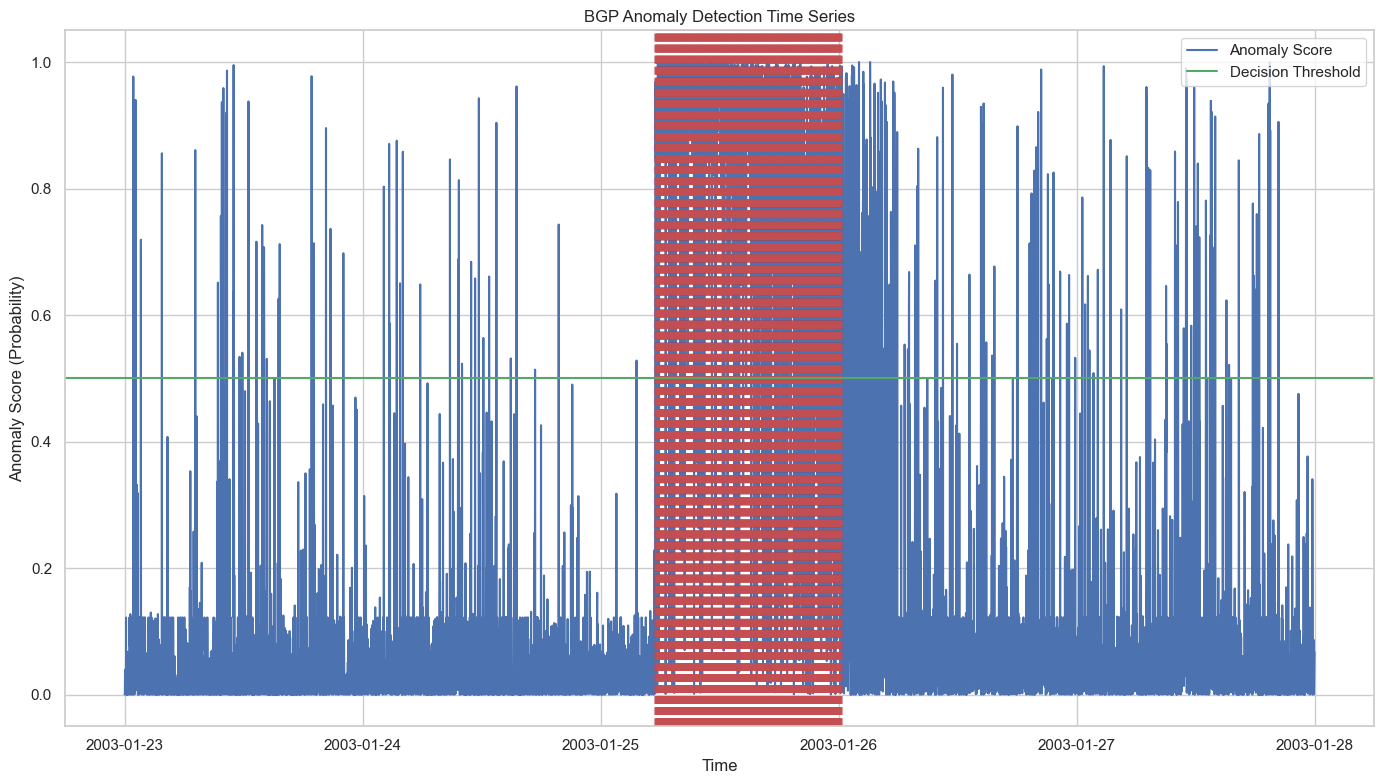

In [21]:
# Load full dataset again to get timestamps
full_df = pd.read_csv(dataset_path)
timestamps = full_df['timestamp']

# Predict probabilities on all data
X_all_selected = X_selected.copy()
all_proba = best_model.predict_proba(X_all_selected)[:, 1]

# Create time series dataframe
time_series_df = pd.DataFrame({
    'timestamp': timestamps,
    'anomaly_score': all_proba,
    'true_class': y
})

# Convert timestamp strings to datetime objects if not already
time_series_df['timestamp'] = pd.to_datetime(time_series_df['timestamp'])

# Plot anomaly score time series
plt.figure(figsize=(14, 8))
plt.plot(time_series_df['timestamp'], time_series_df['anomaly_score'], 'b-', label='Anomaly Score')

# Highlight actual anomaly periods
anomaly_periods = time_series_df[time_series_df['true_class'] == 1]
for idx, row in anomaly_periods.iterrows():
    plt.axvline(x=row['timestamp'], color='r', linestyle='--', alpha=0.3)

# Add horizontal line at threshold 0.5
plt.axhline(y=0.5, color='g', linestyle='-', label='Decision Threshold')

plt.title('BGP Anomaly Detection Time Series')
plt.xlabel('Time')
plt.ylabel('Anomaly Score (Probability)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 9. Feature Importance Analysis with Linear SVM

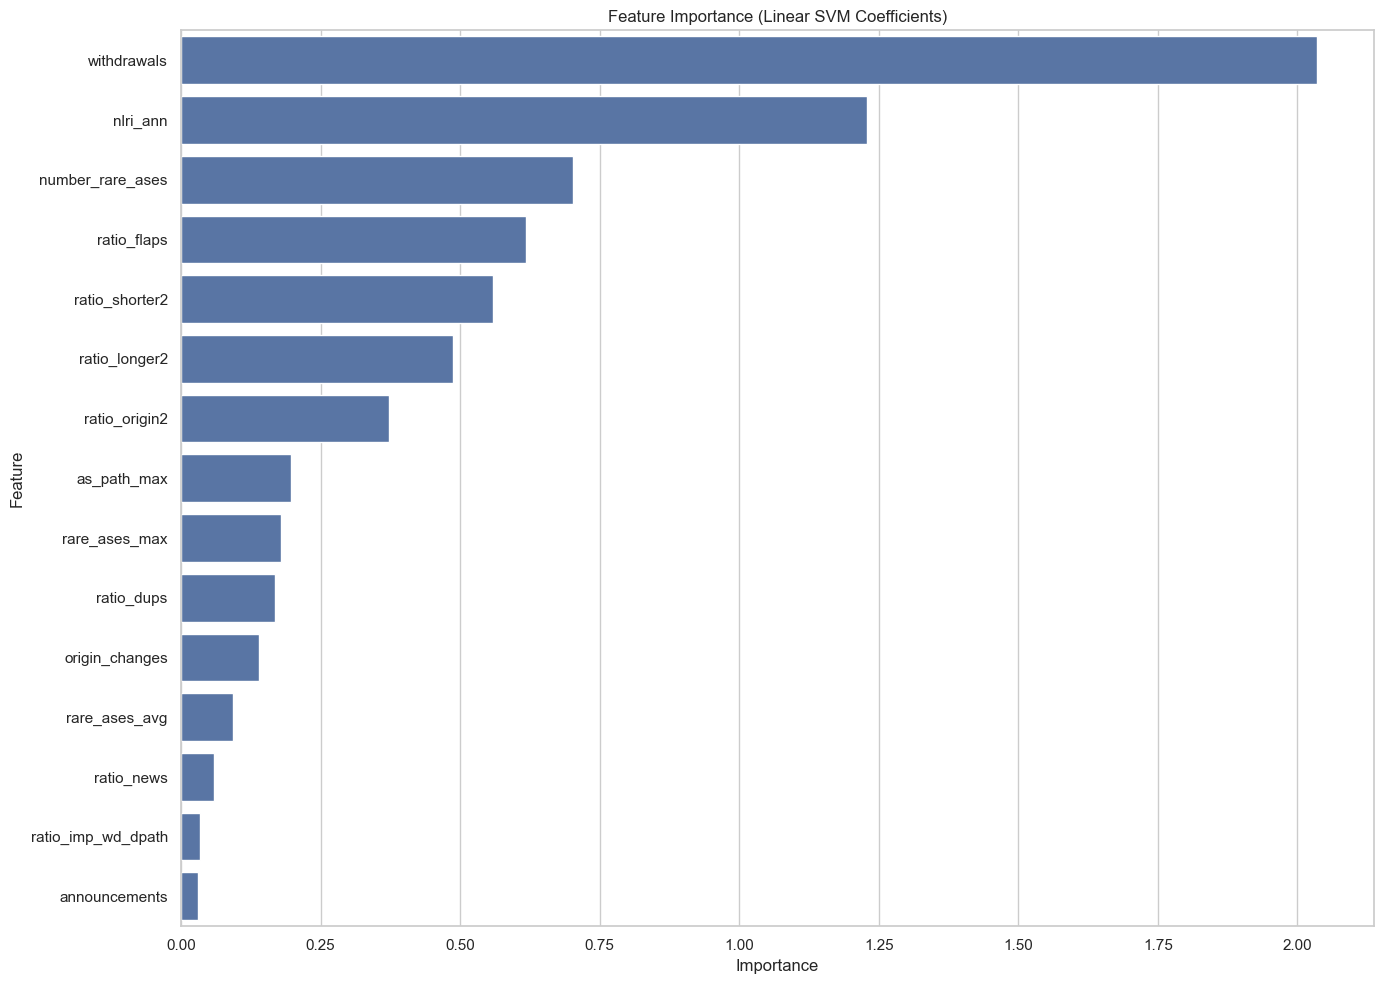

In [22]:
# Create and train a linear SVM for feature importance analysis
linear_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear'))
])
linear_svm.fit(X_train, y_train)

# Extract feature importance scores (coefficients)
importances = abs(linear_svm.named_steps['svm'].coef_[0])
feature_importance = pd.DataFrame({'Feature': X_selected.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Linear SVM Coefficients)')
plt.tight_layout()
plt.show()

## 10. SHAP Values for Model Explainability

SHAP (SHapley Additive exPlanations) values allow us to understand how each feature contributes to individual predictions.

100%|██████████| 10/10 [02:39<00:00, 15.95s/it]


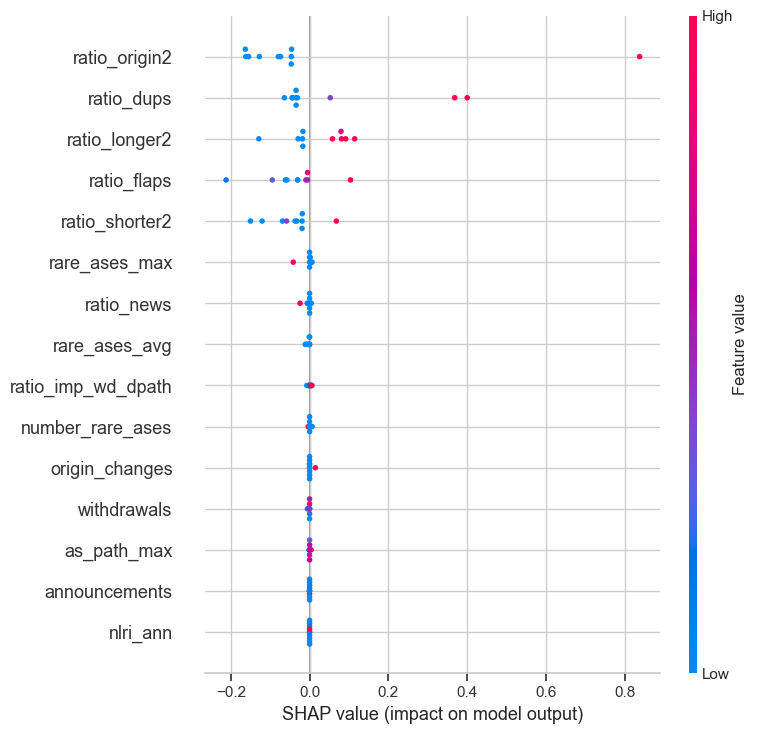

<Figure size 1200x800 with 0 Axes>

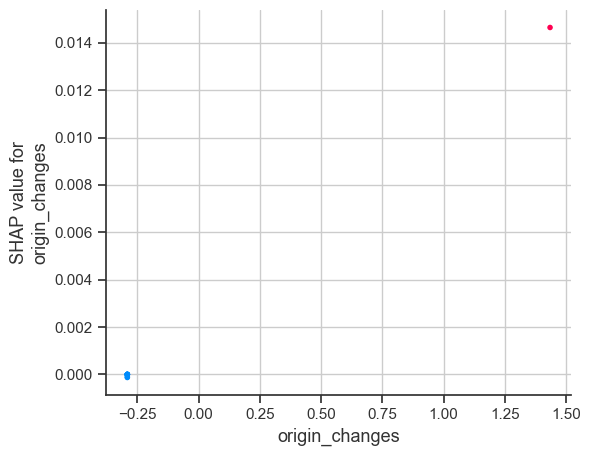

In [23]:
if EXPLAINABILITY_AVAILABLE:
    # Create a simpler model for SHAP analysis (to speed up computation)
    shap_model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='linear', probability=True))
    ])
    shap_model.fit(X_train, y_train)
    
    # Use a subset of training data as background for the explainer
    X_train_sample = X_train.sample(min(100, len(X_train)), random_state=42)
    X_train_transformed = shap_model.named_steps['scaler'].transform(X_train_sample)
    
    # Create a SHAP KernelExplainer
    def f(x):
        return shap_model.predict_proba(x)[:,1]
    
    explainer = shap.KernelExplainer(f, X_train_transformed)
    
    # Select a sample of test instances to explain
    X_test_sample = X_test.sample(min(10, len(X_test)), random_state=42)
    X_test_transformed = shap_model.named_steps['scaler'].transform(X_test_sample)
    
    # Compute SHAP values
    shap_values = explainer.shap_values(X_test_transformed)
    
    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, feature_names=X_selected.columns)
    
    # SHAP dependence plot for top feature
    top_feature_idx = np.argmax(np.abs(explainer.expected_value))
    top_feature = X_selected.columns[top_feature_idx]
    
    plt.figure(figsize=(12, 8))
    shap.dependence_plot(top_feature_idx, shap_values, X_test_transformed, 
                         feature_names=X_selected.columns)
else:
    print("SHAP analysis skipped because libraries are not installed.")

## 11. LIME for Local Interpretability

LIME (Local Interpretable Model-agnostic Explanations) helps understand what features are most important for a specific prediction.

Intercept 0.03005340874497142
Prediction_local [0.48844102]
Right: 0.07385496193993109


<Figure size 1200x600 with 0 Axes>

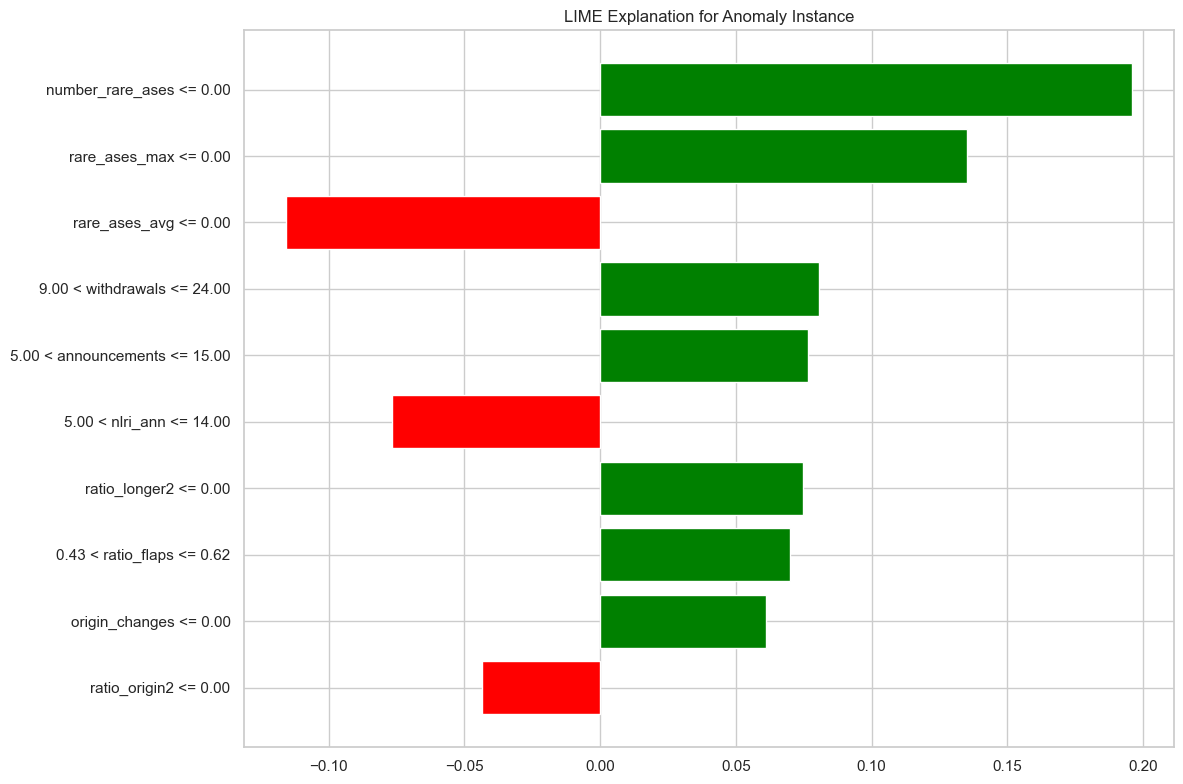

In [24]:
if EXPLAINABILITY_AVAILABLE:
    # Create a LIME explainer
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train.values,
        feature_names=X_selected.columns.tolist(),
        class_names=['Normal', 'Anomaly'],
        verbose=True,
        mode='classification'
    )
    
    # Find an anomaly instance to explain
    anomaly_indices = np.where(y_test == 1)[0]
    if len(anomaly_indices) > 0:
        # Pick an anomaly in the test set
        anomaly_idx = anomaly_indices[0]
        anomaly_instance = X_test.iloc[anomaly_idx].values
        
        # Generate LIME explanation
        lime_exp = lime_explainer.explain_instance(
            anomaly_instance, 
            best_model.predict_proba,
            num_features=10
        )
        
        # Plot the explanation
        plt.figure(figsize=(12, 6))
        lime_exp.as_pyplot_figure()
        plt.title("LIME Explanation for Anomaly Instance")
        plt.tight_layout()
        plt.show()
    else:
        print("No anomalies found in test set")
else:
    print("LIME analysis skipped because libraries are not installed.")

## 12. Model Persistence

Save the trained model for future use.

In [25]:
# Save the model
joblib.dump(best_model, 'svm_slammer_559_1min_model.pkl')
print("Model saved to 'bgp_anomaly_svm_model.pkl'")

# Save the feature list
pd.DataFrame(top_features, columns=['Feature']).to_csv('slammer_559_1_bgp_anomaly_selected_features.csv', index=False)
print("Selected features saved to 'bgp_anomaly_selected_features.csv'")

Model saved to 'bgp_anomaly_svm_model.pkl'
Selected features saved to 'bgp_anomaly_selected_features.csv'


## 13. Loading the Model for Future Predictions

Here's how you would load the model and make predictions on new data.

In [26]:
# Example of how to load and use the model
loaded_model = joblib.load('svm_slammer_559_1min_model.pkl')
selected_features = pd.read_csv('slammer_559_1_bgp_anomaly_selected_features.csv')['Feature'].tolist()

# Example with new data (replace with actual new data)
# new_data = pd.read_csv('new_bgp_data.csv')
# X_new = new_data[selected_features]
# predictions = loaded_model.predict(X_new)
# anomaly_scores = loaded_model.predict_proba(X_new)[:, 1]

print("Model and feature list loaded successfully.")

Model and feature list loaded successfully.


## 14. Conclusion

In this notebook, we've built an SVM-based anomaly detection system for BGP routing data with comprehensive evaluation and explanations. The model can effectively distinguish between normal BGP traffic and anomalous events based on the features extracted by the BGP Feature Extractor tool.

Key observations:
1. Feature selection is crucial - we identified the most discriminative features
2. SVM with appropriate hyperparameters can achieve high accuracy in detecting anomalies
3. ROC curves and precision-recall curves provide deeper insights into model performance
4. SHAP and LIME explain what features contribute most to anomaly predictions
5. Visualizing the time series of anomaly scores helps understand model behavior over time

This model could be deployed as part of a network monitoring system to provide early warning of potential BGP anomalies, helping to secure internet routing infrastructure.